**What is this about?**

Apples are one of the most important temperate fruit crops in the world. Foliar (leaf) diseases pose a major threat to the overall productivity and quality of apple orchards. The current process for disease diagnosis in apple orchards is based on manual scouting by humans, which is time-consuming and expensive.

Although computer vision-based models have shown promise for plant disease identification, there are some limitations that need to be addressed. Large variations in visual symptoms of a single disease across different apple cultivars, or new varieties that originated under cultivation, are major challenges for computer vision-based disease identification. These variations arise from differences in natural and image capturing environments, for example, leaf color and leaf morphology, the age of infected tissues, non-uniform image background, and different light illumination during imaging etc.

Plant Pathology 2020-FGVC7 challenge competition had a pilot dataset of 3,651 RGB images of foliar disease of apples. For Plant Pathology 2021-FGVC8, we have significantly increased the number of foliar disease images and added additional disease categories. This year’s dataset contains approximately 23,000 high-quality RGB images of apple foliar diseases, including a large expert-annotated disease dataset. This dataset reflects real field scenarios by representing non-homogeneous backgrounds of leaf images taken at different maturity stages and at different times of day under different focal camera settings.





# **Specific Objectives**

The main objective of the competition is to develop machine learning-based models to accurately classify a given leaf image from the test dataset to a particular disease category, and to identify an individual disease from multiple disease symptoms on a single leaf image.

# **Resources**
I thank Kaggle for providing the dataset and [Data](http://https://bsapubs.onlinelibrary.wiley.com/doi/10.1002/aps3.11390)
without whom this wouldn't have been Possible.
Also I would like to thank [Ankur Singh](http://https://www.kaggle.com/ankursingh12/resized-plant2021) for this amazing dataset as without it , it would have taken hours and hours to train the below mentioned model.

# Import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing import image
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, smart_resize
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.constraints import maxnorm
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import cv2
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from keras.metrics import AUC

pd.set_option("display.max_columns", None)

# **Let's Now Have a look at the Dataset and Study it better**

I would like to thank [Praveen](http://https://www.kaggle.com/praveengovi/plant-pathology-detail-eda-pytorch) for this amazing EDA and analysis and also [Arnab](http://https://www.kaggle.com/arnabs007/apple-leaf-diseases-with-inceptionresnetv2-keras) from whom I have taken reference from . I have implemented various EDA and studied from their models and approached it with Transfer Learning Model of ResNet 50v2 base.


In [ ]:
train_dir= '../input/plant-pathology-2021-fgvc8/train_images'
test_dir =  '../input/plant-pathology-2021-fgvc8/test_images'
train = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
#print(len(train))
#print(train.columns)
# print(train['labels'].value_counts())
#print(train['labels'].value_counts().plot.bar())

# Let's Study the dataset in a better way and try to find some interesting stuff!!!

In [ ]:
train.head

**We get to know that we have "many" images with mostly 12 types of labels (but there is a twist) which we will comeback to later.**

Let's look at the number of images for various of 12 categories present

In [ ]:
train['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


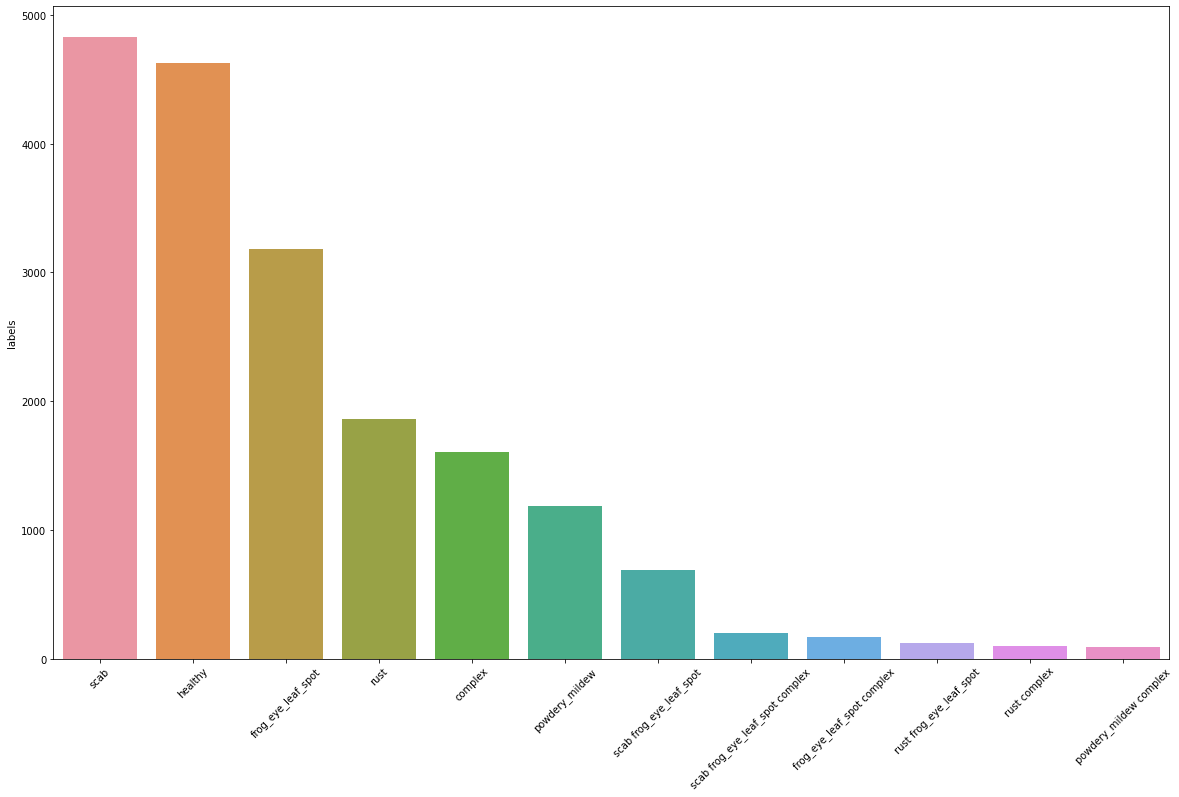

In [ ]:
plt.figure(figsize=(20,12))
labels = sns.barplot(train.labels.value_counts().index,train.labels.value_counts())
for item in labels.get_xticklabels():
    item.set_rotation(45)

**Note**

Notice that there is a huge imbalance in dataset with "scab" having the highest number of frequency and "powdery_mildew complex" , the least

# Important Observation

**Look at the labels, doesn't it strike you ??**

**Some of the labels are mixture of one or more types !!! And thus the problem becomes Multilabel Problem**


So there are not 12 labels, its actually just 6 labels.
5 diseases:
1. rust
2. scab
3. complex
4. frog eye leaf spot
5. powdery mildew

and another label is

6. healthy (healthy leaves)

Now the most important thing is, as one image can have multiple diseases, that means this problem is **Multi label classification** problem. Many get confused betweeen multilabel and multiclass classification. if you are new to multilabel classification I would suggest going over this [An introduction to MultiLabel classification](https://www.geeksforgeeks.org/an-introduction-to-multilabel-classification/) .

So now we gotta process the labels. And then lets find out the actual frequencies of the labels.


We divide it based on " " or space character , in order to get the labels for each of the image

In [ ]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
18627,fffb900a92289a33.jpg,[healthy]
18628,fffc488fa4c0e80c.jpg,[scab]
18629,fffc94e092a59086.jpg,[rust]
18630,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Converting the labels representation into **one hot encoded format** using MultilabelBinarizer from Scikit learn. Now we can see and plot the frequencies of each label.

In [ ]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')


These are the 6 different labels

In [ ]:
print(trainx.sum())

complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                  2077
scab                  5712
dtype: int64


<AxesSubplot:>

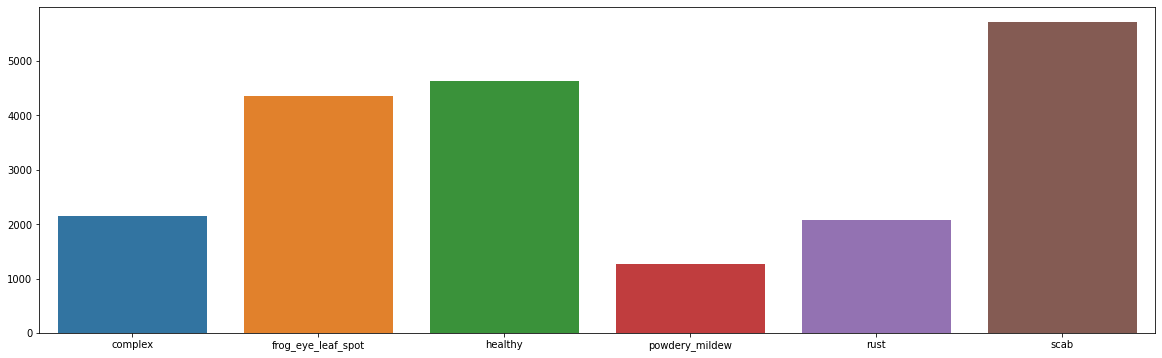

In [ ]:
labels = list(trainx.sum().keys())
#print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

**NOW WE CAN SEE THE DATASET BECOMES MORE OR LESS BALANCED , AT LEAST BETTER THAN WHAT IT WAS PREVIOUSLY!**

# Let's See the Plant Pathology Images

In [ ]:
labels = pd.concat([train['image'], trainx], axis=1)
labels.head()

,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,1,1,0,0,0,1
2,80070f7fb5e2ccaa.jpg,0,0,0,0,0,1
3,80077517781fb94f.jpg,0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,1,0,0,0,0,0


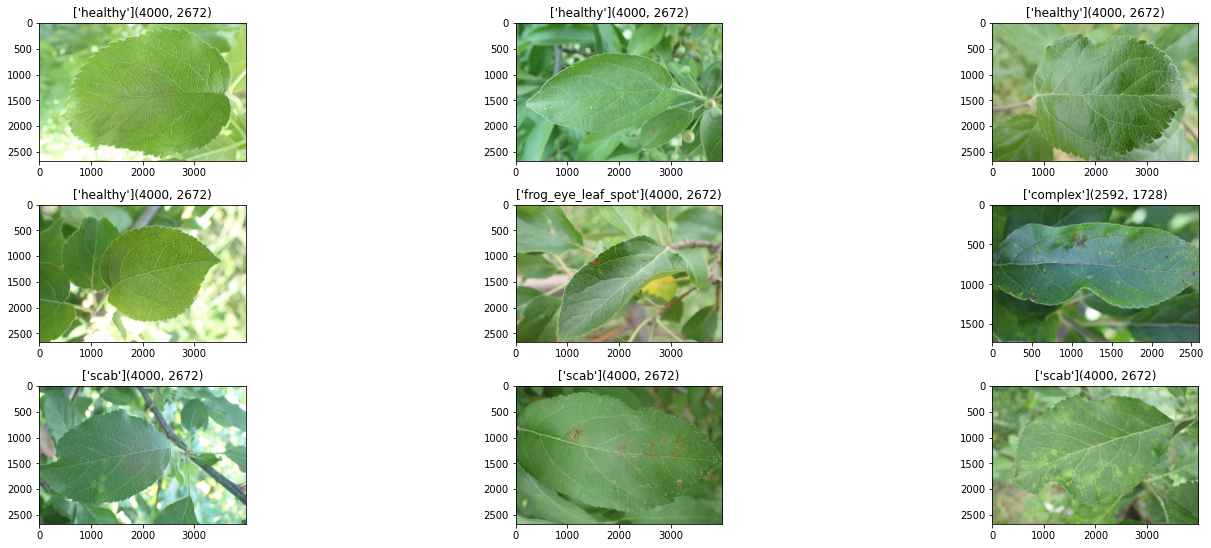

In [ ]:
fig1 = plt.figure(figsize=(20,10))

for i in range(1, 10):

    rand =  random.randrange(1, 18000)
    sample = os.path.join('../input/plant-pathology-2021-fgvc8/train_images/', train['image'][rand])

    img = PIL.Image.open(sample)

    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)

    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)

    fig1.tight_layout()


# Imaze Size & Processing
from the titles we can see some random image sizes - (4000, 2672). Larger images are harder to process hence takes much longer to train the CNN. Downsampling all these 18632 images is also a time consuming task. This is I am going to use the resized imaged for this dataset [resized-plant2021](https://www.kaggle.com/ankursingh12/resized-plant2021) by Ankur Singh. He has already downsampled the images into size of 256, 384, 512 & 640px.
Now for Pre Processing I take help of the [Keras Image Data Generator](http://https://keras.io/api/preprocessing/image/). We transform it to size of (256,256,3) .

In [ ]:
from sklearn.model_selection import train_test_split

# 5. Training and validation split

train_df, valid_df = train_test_split(train, test_size=0.2 )
print(f'Number of train images: {len(train_df)} and validation images: {len(valid_df)}')

Number of train images: 14905 and validation images: 3727


In [ ]:
%%time
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                        preprocessing_function=None,
                                                        data_format=None,
                                                    )

train_data = datagen.flow_from_dataframe(
    train_df,
    directory= '../input/resized-plant2021/img_sz_512',
    x_col="image",
    y_col= 'labels',
    color_mode="rgb",
    target_size = (256,256),
    class_mode="categorical",
    batch_size=32,
    shuffle=False,
    seed=40,
)
valid_data = datagen.flow_from_dataframe(
    valid_df,
    directory= '../input/resized-plant2021/img_sz_512',
    x_col="image",
    y_col= 'labels',
    color_mode="rgb",
    target_size = (256,256),
    class_mode="categorical",
    batch_size=32,
    shuffle=False,
    seed=40,
)

Found 14905 validated image filenames belonging to 6 classes.
Found 3727 validated image filenames belonging to 6 classes.
CPU times: user 391 ms, sys: 366 ms, total: 757 ms
Wall time: 41.2 s


# Transfer Learning Using ResNet 50V2 Base

[Transfer learning](http://builtin.com/data-science/transfer-learning) In transfer learning, the knowledge of an already trained machine learning model is applied to a different but related problem. For example, if you trained a simple classifier to predict whether an image contains a backpack, you could use the knowledge that the model gained during its training to recognize other objects like sunglasses.
With transfer learning, we basically try to exploit what has been learned in one task to improve generalization in another. We transfer the weights that a network has learned at "task A" to a new "task B".
Here I will use ResNet 50V2 model, and load the previously saved weights from the "imagenet" competition . [ResNet 50 ](http://https://keras.io/api/applications/resnet/) is a famous model, which won the ImageNet Competition in 2016, it is based on the idea of residual networks. ResNet 50V2 is a modified version of ResNet 50 which I am going to use here now.


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rn
import numpy as np
import os

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import MaxPooling2D,GlobalAveragePooling2D,BatchNormalization,Activation
from tensorflow import keras
from keras import backend as K

%matplotlib inline

In [ ]:
seed = 1200
tf.random.set_seed(seed)
input_shape= (256,256,3)
#weights_path = '../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
#model = keras.applications.InceptionResNetV2(weights=weights_path, include_top=False, input_shape=(256, 256, 3))
base_model = ResNet50V2(input_shape=input_shape, include_top=False,weights= "imagenet")
base_model.trainable = False
print(base_model.input)
print(base_model.output)

94674944/94668760 [==============================] - 1s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 2048), dtype=tf.float32, name=None), name='post_relu/Relu:0', description="created by layer 'post_relu'")


# Model Architecture and Information

As mentioned above here I used a ResNet 50V2 based model. So,first we need to keep in mind that we **should not** train the layers of the ResNet part of the model. Because it has already been trained for 1000 classes of image. So what we need to do , is to remove the last Fully Connected Layer and then build our model based upon it . After various changes to the model, I noticed that the model overfits whenever I add more than one layer in between the base model i.e ResNet 50V2 and the final layer . So I only added a single layer with BatchNormalisation and a Dropout layer , before giving out the outputs.


# Dealing with Multi Label Classification

Out general thught when we come across more than one classes , is to use "softmax" activation function in the last layer . But remember as this is a multilabel classification problem, we can't use softmax here, hence the sigmoid activation.
Another thing to keep in mind is that Binary crossentropy is used instead of categorical crossentropy. We use categorical cross-entropy in multi-class problems, but for multi-label problems, we use binary cross-entropy. Think of it this way, an image may have multiple labels, and we need the probabilities that each of these labels corresponds to the given image - this can be considered as n independent binary classifiers for the n labels.

For evaluation I have used F1 accuracy metrics instead of binary accuracy. F1 and its variants are better for evaluation when it comes to multiclass and multilabel problems. if you want to know F1 score works for Multilabel classification go through this https://medium.com/synthesio-engineering/precision-accuracy-and-f1-score-for-multi-label-classification-34ac6bdfb404https://medium.com/synthesio-engineering/precision-accuracy-and-f1-score-for-multi-label-classification-34ac6bdfb404.

In [ ]:

# Freezing the weights
for layer in base_model.layers[:-1]:
    layer.trainable=False

#new_model.summary()

classes = 6
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
x = Dense(1024,activation='relu')(x)

x = BatchNormalization()(x)

#x = Dropout(0.10)(x)

#x = Dense(1024,activation= 'relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.50)(x)#jn

output = Dense(classes,activation='sigmoid')(x)

In [ ]:
from keras.models import load_model
f1 = tfa.metrics.F1Score(num_classes=6, average='macro')

callbacks = keras.callbacks.EarlyStopping(monitor=f1, patience=3, mode='max', restore_best_weights=True)
threshold_x=0.25
optimizer = Adam(learning_rate = 0.0001)
f1 = tfa.metrics.F1Score(num_classes=6, average='macro',threshold = threshold_x)
callbacks = keras.callbacks.EarlyStopping(monitor=f1, patience=3, mode='max', restore_best_weights=True)
model = tf.keras.Model(inputs = base_model.input, outputs = output)
#model = load_model("../input/resnet50-v2")
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer,metrics=[f1])
# Compile the model with additional metrics
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy', f1, auc]
)
model.fit(train_data, epochs=15, callbacks=callbacks)

NameError: name 'auc' is not defined

In [ ]:
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import tensorflow_addons as tfa

# Assuming base_model and output are defined earlier in your code

# Define F1 score threshold
threshold_x = 0.25

# Create F1 metric for training and validation
f1 = tfa.metrics.F1Score(num_classes=6, average='macro', threshold=threshold_x)
f1_val = tfa.metrics.F1Score(num_classes=6, average='macro', threshold=threshold_x)

# Define AUC metric for training and validation
auc = AUC()
auc_val = AUC()

# Define optimizer
optimizer = Adam(learning_rate=0.0001)

# Define early stopping callback
callbacks = keras.callbacks.EarlyStopping(monitor='val_f1', patience=3, mode='max', restore_best_weights=True)

# Define the model
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile the model with additional metrics
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy', f1, auc]
)

# Train the model with validation data
history = model.fit(
    train_data,
    epochs=15,
    validation_data=valid_data,
    callbacks=[callbacks],
)

# Optionally, you can retrieve the history to access training and validation metrics
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']
train_auc = history.history['auc']
val_auc = history.history['val_auc']


Epoch 1/15
466/466 [==============================] - 147s 300ms/step - loss: 0.5830 - accuracy: 0.5476 - f1_score: 0.3566 - auc: 0.8104 - val_loss: 0.3333 - val_accuracy: 0.6965 - val_f1_score: 0.5587 - val_auc: 0.9167
Epoch 2/15
466/466 [==============================] - 75s 162ms/step - loss: 0.3017 - accuracy: 0.7462 - f1_score: 0.5549 - auc: 0.9291 - val_loss: 0.2557 - val_accuracy: 0.7113 - val_f1_score: 0.6933 - val_auc: 0.9259
Epoch 3/15
466/466 [==============================] - 75s 161ms/step - loss: 0.2133 - accuracy: 0.7878 - f1_score: 0.7370 - auc: 0.9538 - val_loss: 0.2369 - val_accuracy: 0.7196 - val_f1_score: 0.7139 - val_auc: 0.9320
Epoch 4/15
466/466 [==============================] - 75s 162ms/step - loss: 0.1846 - accuracy: 0.8101 - f1_score: 0.7829 - auc: 0.9641 - val_loss: 0.2276 - val_accuracy: 0.7494 - val_f1_score: 0.7320 - val_auc: 0.9382
Epoch 5/15
466/466 [==============================] - 76s 162ms/step - loss: 0.1648 - accuracy: 0.8296 - f1_score: 0.8089 -

In [ ]:
model.save('ResNet50Base12.h5')

# But How to Submit the Results?

For submission I will resize the test images as I did for the train images , and doing the same operations as the train set and then predict the labels for them.

**Remember, since we cannot use the internet while submitting the solution , we should download the model as a ".h5" file , then upload it into Input Folder and finally load the model , for predicting**

In [ ]:
test = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')

for img_name in tqdm(test['image']):
    path = '../input/plant-pathology-2021-fgvc8/test_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((256,256))
        img.save(f'./{img_name}')



In [ ]:
from keras.models import load_model
model = load_model("../input/resnet-50v2final/ResNet50Base12.h5")


In [ ]:
test_data = datagen.flow_from_dataframe(
    test,
    directory = './',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (256,256),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

preds = model.predict(test_data)
print(preds)
preds = preds.tolist()

indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=0.25:
            temp.append(pred.index(category))
    if temp!=[]:
        indices.append(temp)
    else:
        temp.append(np.argmax(pred))
        indices.append(temp)

print(indices)

In [ ]:

labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels)


Remove the resized images from output before submission. if there are any other files present except 'submission.csv' it will throw an error when submitting.

In [ ]:

delfiles = tf.io.gfile.glob('./*.jpg')

for file in delfiles:
    os.remove(file)


In [ ]:

sub = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
sub['labels'] = testlabels
sub.to_csv('submission.csv', index=False)
sub
